## MOUNTING DRIVE & INSTALL

In [3]:
from google.colab import drive
import os
import shutil

drive.mount('/content/drive')

DRIVE_FOLDER = "/content/drive/MyDrive/FirecastRL_Models"

zip_path = f"{DRIVE_FOLDER}/wildfire-env.zip"

if os.path.exists(zip_path):
    print(f"✅ Found zip at {zip_path}")

    !cp "$zip_path" .

    !unzip -o -q wildfire-env.zip
    print("✅ Unzipped successfully.")
else:
    print(f"❌ CRITICAL ERROR: Could not find wildfire-env.zip in {DRIVE_FOLDER}")
    print("Please check your Drive folder name.")

!pip install gymnasium stable-baselines3 shimmy pygame

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Found zip at /content/drive/MyDrive/FirecastRL_Models/wildfire-env.zip
✅ Unzipped successfully.


## FIXING IMPORTS FOR THE ENV(DRIVE IMPORT ERR)

In [4]:
import sys
import os

if os.path.exists("wildfire-env"):
    if os.path.exists("wildfire-env/firecastrl_env"):
        sys.path.append(os.path.abspath("wildfire-env"))
    else:
        if os.path.exists("firecastrl_env"):
            shutil.rmtree("firecastrl_env")
        os.rename("wildfire-env", "firecastrl_env")
        sys.path.append(os.path.abspath("."))

try:
    from firecastrl_env.envs.wildfire_env import WildfireEnv
    from firecastrl_env.envs.environment import helper
    from firecastrl_env.envs.environment.enums import FireState
    print("✅ Environment imported successfully.")
except ImportError as e:
    print(f"❌ Import Failed: {e}")

✅ Environment imported successfully.


## V2 WRAPPERS Definition

In [5]:
import gymnasium as gym
import numpy as np


# Fixes the 'Blindness' problem. Neural Networks hate large numbers (like x=200), This squashes everything between 0 and 1.
class SmartNormalizeWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.grid_w = env.gridWidth
        self.grid_h = env.gridHeight

    def observation(self, obs):

        grid = obs['cells']
        # Replacing infinity with -1 (safe), scale burning times
        grid = np.nan_to_num(grid, posinf=-1.0)
        # Scaling large time numbers (e.g. 500.0) down to small range
        grid = np.clip(grid / 1000.0, -1.0, 1.0)
        obs['cells'] = grid

        # Normalizing Helicopter Coordinates
        # [120, 80] becomes [0.5, 0.5]
        coords = obs['helicopter_coord'].astype(np.float32)
        coords[:, 0] /= float(self.grid_w) # Normalize X
        coords[:, 1] /= float(self.grid_h) # Normalize Y
        obs['helicopter_coord'] = coords

        return obs

# Fixes the 'Border Hugger' problem. Gives small rewards for moving towards fire, and reduces penalties so the agent isn't afraid to experiment.
class BreadcrumbRewardWrapper(gym.Wrapper):

    def __init__(self, env):
        super().__init__(env)

    def step(self, action):
        obs, _, term, trunc, info = self.env.step(action)

        reward = 0.0

        # Big Reward for Extinguishing (The Goal)
        extinguished = self.env.unwrapped.state['quenched_cells'][0]
        reward += 10.0 * extinguished

        # Breadcrumb Reward (Proximity)
        if info['cells_burning'] > 0:
            reward += self._calculate_proximity_bonus()

        # Soft Wasted Water Penalty
        reward -= self._check_waste() * 0.5

        return obs, float(reward), term, trunc, info

    # Give a tiny bonus if an agent is near a burning cell
    def _calculate_proximity_bonus(self):
        bonus = 0.0
        base = self.env.unwrapped

        # Get burning locations
        fire_indices = np.argwhere(base.state['cells'] > 0)
        if len(fire_indices) < 10: return 0.0 # Ignore if fire is tiny

        # Approx center of fire mass
        fire_center = np.mean(fire_indices, axis=0)

        for i in range(base.num_agents):
            hx, hy = base.state['helicopter_coord'][i]
            # Calculate distance to fire center (normalized approx)
            dist = np.sqrt((hx - fire_center[1])**2 + (hy - fire_center[0])**2)

            # If reasonably close (within ~50 pixels), give tiny reward
            if dist < 50.0:
                bonus += 0.05

        return bonus

    def _check_waste(self):
        pen = 0.0
        base = self.env.unwrapped
        for i in range(base.num_agents):
            if base.state['last_action'][i] == 4:
                x, y = base.state['helicopter_coord'][i]
                idx = helper.get_grid_index_for_location(x, y, base.gridWidth)
                if base.cells[idx].fireState != FireState.Burning:
                    pen += 1.0
        return pen

## TRAINING V2

In [6]:
# training version 2 of the model with normalization
from stable_baselines3 import PPO

print("🚀 Starting V2 Training (Normalized)...")

# initializing the base environment with three agents
raw_env = WildfireEnv(num_agents=3, render_mode=None)

# applying normalization and breadcrumb reward wrappers
norm_env = SmartNormalizeWrapper(raw_env)
v2_env = BreadcrumbRewardWrapper(norm_env)

# training using higher learning rate due to dense reward structure
model = PPO("MultiInputPolicy", v2_env, verbose=1, learning_rate=0.0003)
model.learn(total_timesteps=150_000)

# saving the trained model to google drive
save_path = f"{DRIVE_FOLDER}/ppo_fire_squad_v2_normalized"
model.save(save_path)
print(f"✅ V2 Model Saved to: {save_path}.zip")

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


🚀 Starting V2 Training (Normalized)...
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 502      |
|    ep_rew_mean     | -86.1    |
| time/              |          |
|    fps             | 28       |
|    iterations      | 1        |
|    time_elapsed    | 71       |
|    total_timesteps | 2048     |
---------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 553        |
|    ep_rew_mean          | -72.4      |
| time/                   |            |
|    fps                  | 29         |
|    iterations           | 2          |
|    time_elapsed         | 137        |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.00722687 |
|    clip_fraction        | 0.0852     |
|    clip_range           | 0.2        |
|    entropy_loss         | -4.82      |
|    explained_variance   | 0.00048    |
|    learning_rate        | 0.0003     |
|    loss                 | 6.21       |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.00675   |
|    value_loss           | 93.1       |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 596         |
|    ep_rew_m

## TRAINING V3 (WITH VISION/CNN)

In [8]:
# training version 3 with cnn vision support
from stable_baselines3 import PPO
import gymnasium as gym
import numpy as np

# defining wrapper to handle image observations
class VisionWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        # setting observation space to channel first format
        h, w = env.gridHeight, env.gridWidth
        self.observation_space = gym.spaces.Dict({
            'cells': gym.spaces.Box(low=-1.0, high=1.0, shape=(1, h, w), dtype=np.float32),
            'helicopter_coord': env.observation_space['helicopter_coord'],
            'quenched_cells': env.observation_space['quenched_cells']
        })
        self.grid_w = w
        self.grid_h = h

    def observation(self, obs):
        # normalizing grid values and adding channel dimension
        grid = obs['cells']
        grid = np.nan_to_num(grid, posinf=-1.0)
        grid = np.clip(grid / 1000.0, -1.0, 1.0)

        # reshaping grid to include channel dimension
        new_grid = grid.reshape(1, self.grid_h, self.grid_w)
        obs['cells'] = new_grid.astype(np.float32)

        # normalizing helicopter coordinates relative to grid size
        coords = obs['helicopter_coord'].astype(np.float32)
        coords[:, 0] /= float(self.grid_w)
        coords[:, 1] /= float(self.grid_h)
        obs['helicopter_coord'] = coords

        return obs

print("🚀 Starting V3 Training (CNN Vision)...")

# initializing raw environment
raw_env = WildfireEnv(num_agents=3, render_mode=None)

# wrapping environment to enable cnn processing
vision_env = VisionWrapper(raw_env)

# applying breadcrumb reward wrapper
final_env = BreadcrumbRewardWrapper(vision_env)

# initializing ppo model with multi-input policy
model = PPO("MultiInputPolicy", final_env, verbose=1)
model.learn(total_timesteps=150_000)

# saving model to defined path
path = f"{save_dir}/ppo_fire_squad_v3_cnn"
model.save(path)
print(f"✅ V3 CNN Model Saved to: {path}.zip")

🚀 Starting V3 Training (CNN Vision)...
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 642      |
|    ep_rew_mean     | -152     |
| time/              |          |
|    fps             | 33       |
|    iterations      | 1        |
|    time_elapsed    | 60       |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 655         |
|    ep_rew_mean          | -53.8       |
| time/                   |             |
|    fps                  | 31          |
|    iterations           | 2           |
|    time_elapsed         | 128         |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.022318196 |
|    clip_fraction        | 0.287       |
|    clip_range       

NameError: name 'save_dir' is not defined

In [9]:

# Saving model path fix
path = f"{DRIVE_FOLDER}/ppo_fire_squad_v3_cnn"
model.save(path)
print(f"✅ V3 CNN Model Saved to: {path}.zip")

✅ V3 CNN Model Saved to: /content/drive/MyDrive/FirecastRL_Models/ppo_fire_squad_v3_cnn.zip


## EVALUATING V3

In [11]:
import pandas as pd
import numpy as np
from stable_baselines3 import PPO

# redefining wrapper class to ensure local scope access
class VisionWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        h, w = env.gridHeight, env.gridWidth
        self.observation_space = gym.spaces.Dict({
            'cells': gym.spaces.Box(low=-1.0, high=1.0, shape=(1, h, w), dtype=np.float32),
            'helicopter_coord': env.observation_space['helicopter_coord'],
            'quenched_cells': env.observation_space['quenched_cells']
        })
        self.grid_w = w
        self.grid_h = h

    def observation(self, obs):
        grid = obs['cells']
        grid = np.nan_to_num(grid, posinf=-1.0)
        grid = np.clip(grid / 1000.0, -1.0, 1.0)
        new_grid = grid.reshape(1, self.grid_h, self.grid_w)
        obs['cells'] = new_grid.astype(np.float32)

        coords = obs['helicopter_coord'].astype(np.float32)
        coords[:, 0] /= float(self.grid_w)
        coords[:, 1] /= float(self.grid_h)
        obs['helicopter_coord'] = coords
        return obs

def evaluate_v3(model_path, episodes=10):
    print(f"🔍 Evaluating V3 (CNN) Model...")

    raw_env = WildfireEnv(num_agents=3, render_mode=None)
    # applying vision wrapper for evaluation environment
    env = VisionWrapper(raw_env)

    try:
        model = PPO.load(model_path)
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return

    burnt_counts = []
    steps_counts = []

    for i in range(episodes):
        obs, _ = env.reset()
        done = False
        steps = 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, _, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            steps += 1

        burnt_counts.append(info['cells_burnt'])
        steps_counts.append(steps)
        print(f"   Run {i+1}: Burnt {info['cells_burnt']} (Steps: {steps})")

    print("\n📊 V3 RESULTS:")
    print(f"   Mean Burnt: {np.mean(burnt_counts):.2f} (Std: {np.std(burnt_counts):.2f})")
    print(f"   Mean Steps: {np.mean(steps_counts):.2f}")

# running evaluation using the saved model path
path_v3 = f"{DRIVE_FOLDER}/ppo_fire_squad_v3_cnn"
evaluate_v3(path_v3)

🔍 Evaluating V3 (CNN) Model...
   Run 1: Burnt 1640 (Steps: 791)
   Run 2: Burnt 1640 (Steps: 769)
   Run 3: Burnt 1640 (Steps: 791)
   Run 4: Burnt 1592 (Steps: 698)
   Run 5: Burnt 1441 (Steps: 588)
   Run 6: Burnt 1441 (Steps: 588)
   Run 7: Burnt 301 (Steps: 233)
   Run 8: Burnt 1159 (Steps: 464)
   Run 9: Burnt 1640 (Steps: 791)
   Run 10: Burnt 1592 (Steps: 698)

📊 V3 RESULTS:
   Mean Burnt: 1408.60 (Std: 396.56)
   Mean Steps: 641.10


## RECORDING V3 Video

In [12]:
from gymnasium.wrappers import RecordVideo
from google.colab import files
import glob

def record_v3(model_path):
    print(f"\n🎥 Recording V3 Agent...")

    # initializing environment with rgb array mode
    raw_env = WildfireEnv(num_agents=3, render_mode="rgb_array")
    # applying vision wrapper for cnn compatibility
    env = VisionWrapper(raw_env)

    video_folder = "video_v3_cnn"
    # setting up video recording configuration
    env = RecordVideo(
        env,
        video_folder=video_folder,
        name_prefix="v3_cnn_agent",
        disable_logger=True
    )

    # loading the trained model from path
    model = PPO.load(model_path)

    # running a single episode to record video
    obs, _ = env.reset()
    done = False
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

    env.close()
    print(f"✅ Video saved to {video_folder}/")

    # finding and downloading the recorded video file
    mp4_files = glob.glob(f"{video_folder}/*.mp4")
    if mp4_files:
        files.download(mp4_files[0])

record_v3(path_v3)


🎥 Recording V3 Agent...


/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_re

✅ Video saved to video_v3_cnn/


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## TRAINING V4 (HEAT SEEKER)

In [14]:
from stable_baselines3 import PPO
import gymnasium as gym
import numpy as np
from firecastrl_env.envs.wildfire_env import WildfireEnv
from firecastrl_env.envs.environment import helper
from firecastrl_env.envs.environment.enums import FireState

class HeatSeekerWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.grid_w = env.gridWidth
        self.grid_h = env.gridHeight
        self.prev_distances = [None] * env.num_agents

        # setting up observation space for cnn input
        self.observation_space = gym.spaces.Dict({
            'cells': gym.spaces.Box(low=-1.0, high=1.0, shape=(1, self.grid_h, self.grid_w), dtype=np.float32),
            'helicopter_coord': env.observation_space['helicopter_coord'],
            'quenched_cells': env.observation_space['quenched_cells']
        })

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.prev_distances = [None] * self.env.num_agents
        return self._process_obs(obs), info

    def observation(self, obs):
        return self._process_obs(obs)

    def _process_obs(self, obs):
        # formatting grid values for neural network
        grid = obs['cells']
        grid = np.nan_to_num(grid, posinf=-1.0)
        grid = np.clip(grid / 1000.0, -1.0, 1.0)
        new_grid = grid.reshape(1, self.grid_h, self.grid_w)

        # scaling helicopter coordinates to range zero to one
        coords = obs['helicopter_coord'].astype(np.float32)
        coords[:, 0] /= float(self.grid_w)
        coords[:, 1] /= float(self.grid_h)

        return {
            'cells': new_grid.astype(np.float32),
            'helicopter_coord': coords,
            'quenched_cells': obs['quenched_cells']
        }

    def step(self, action):
        obs, _, term, trunc, info = self.env.step(action)

        # calculating custom rewards based on heat proximity
        reward = 0.0

        # rewarding agents for extinguishing fire
        extinguished = self.env.unwrapped.state['quenched_cells'][0]
        reward += 10.0 * extinguished

        # calculating distance to fire for reward shaping
        base = self.env.unwrapped
        fire_indices = np.argwhere(base.cells_burning_indices() if hasattr(base, 'cells_burning_indices') else (base.state['cells'] > 0))
        # checking for fire indices availability
        if len(fire_indices) == 0:
             # manually scanning grid for fire locations as fallback
             raw_cells = np.array(base.cells)
             fire_indices = np.array([(c.y, c.x) for c in raw_cells if c.fireState == FireState.Burning])

        if len(fire_indices) > 0:
            # calculating center of mass for all active fires
            fire_center_y = np.mean(fire_indices[:, 0])
            fire_center_x = np.mean(fire_indices[:, 1])

            for i in range(base.num_agents):
                hx, hy = base.state['helicopter_coord'][i]

                # measuring distance from agent to fire center
                current_dist = np.sqrt((hx - fire_center_x)**2 + (hy - fire_center_y)**2)

                # checking if distance tracking is initialized
                if self.prev_distances[i] is not None:
                    diff = self.prev_distances[i] - current_dist

                    # rewarding movement towards fire and penalizing retreat
                    reward += diff * 1.0

                self.prev_distances[i] = current_dist

        # penalizing agents for hovering near map edges
        for i in range(base.num_agents):
            hx, hy = base.state['helicopter_coord'][i]
            if hx <= 2 or hx >= self.grid_w - 2 or hy <= 2 or hy >= self.grid_h - 2:
                reward -= 5.0

        return self._process_obs(obs), float(reward), term, trunc, info

print("🚀 Starting V4 Training (Heat Seeker)...")

# initializing raw environment and heat seeker wrapper
raw_env = WildfireEnv(num_agents=3, render_mode=None)
env = HeatSeekerWrapper(raw_env)

# training with lower learning rate due to reward volatility
model = PPO("MultiInputPolicy", env, verbose=1, learning_rate=0.0001)
model.learn(total_timesteps=150_000)

# saving heat seeker model to drive
save_path = f"{DRIVE_FOLDER}/ppo_fire_squad_v4_heatseeker"
model.save(save_path)
print(f"✅ V4 Model Saved to: {save_path}.zip")

🚀 Starting V4 Training (Heat Seeker)...
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 545      |
|    ep_rew_mean     | -301     |
| time/              |          |
|    fps             | 10       |
|    iterations      | 1        |
|    time_elapsed    | 190      |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 583         |
|    ep_rew_mean          | -322        |
| time/                   |             |
|    fps                  | 10          |
|    iterations           | 2           |
|    time_elapsed         | 384         |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.012761335 |
|    clip_fraction        | 0.147       |
|    clip_range      

## EVALUATING V4

In [15]:
import pandas as pd
import numpy as np
import gymnasium as gym
from stable_baselines3 import PPO
from firecastrl_env.envs.wildfire_env import WildfireEnv
from firecastrl_env.envs.environment.enums import FireState

# redefining wrapper to ensure standalone execution
class HeatSeekerWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.grid_w = env.gridWidth
        self.grid_h = env.gridHeight
        self.prev_distances = [None] * env.num_agents

        # setting observation space for cnn input
        self.observation_space = gym.spaces.Dict({
            'cells': gym.spaces.Box(low=-1.0, high=1.0, shape=(1, self.grid_h, self.grid_w), dtype=np.float32),
            'helicopter_coord': env.observation_space['helicopter_coord'],
            'quenched_cells': env.observation_space['quenched_cells']
        })

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.prev_distances = [None] * self.env.num_agents
        return self._process_obs(obs), info

    def observation(self, obs):
        return self._process_obs(obs)

    def step(self, action):
        # executing step and returning processed observation
        obs, reward, term, trunc, info = self.env.step(action)
        return self._process_obs(obs), reward, term, trunc, info

    def _process_obs(self, obs):
        grid = obs['cells']
        grid = np.nan_to_num(grid, posinf=-1.0)
        grid = np.clip(grid / 1000.0, -1.0, 1.0)
        new_grid = grid.reshape(1, self.grid_h, self.grid_w)

        coords = obs['helicopter_coord'].astype(np.float32)
        coords[:, 0] /= float(self.grid_w)
        coords[:, 1] /= float(self.grid_h)

        return {
            'cells': new_grid.astype(np.float32),
            'helicopter_coord': coords,
            'quenched_cells': obs['quenched_cells']
        }

def evaluate_v4(model_path, episodes=10):
    print(f"🔍 Evaluating V4 (Heat Seeker) Model...")

    # initializing raw environment
    raw_env = WildfireEnv(num_agents=3, render_mode=None)
    # applying heat seeker wrapper for cnn shape compatibility
    env = HeatSeekerWrapper(raw_env)

    try:
        model = PPO.load(model_path)
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return

    burnt_counts = []
    steps_counts = []

    for i in range(episodes):
        obs, _ = env.reset()
        done = False
        steps = 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, _, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            steps += 1

        burnt_counts.append(info['cells_burnt'])
        steps_counts.append(steps)
        print(f"   Run {i+1}: Burnt {info['cells_burnt']} (Steps: {steps})")

    print("\n📊 V4 HEAT SEEKER RESULTS:")
    print(f"   Mean Burnt: {np.mean(burnt_counts):.2f} (Std: {np.std(burnt_counts):.2f})")
    print(f"   Mean Steps: {np.mean(steps_counts):.2f}")

# defining save directory manually if needed
save_dir = "/content/drive/MyDrive/FirecastRL_Models"
path_v4 = f"{save_dir}/ppo_fire_squad_v4_heatseeker"
evaluate_v4(path_v4)

🔍 Evaluating V4 (Heat Seeker) Model...
   Run 1: Burnt 1640 (Steps: 791)
   Run 2: Burnt 1441 (Steps: 588)
   Run 3: Burnt 1592 (Steps: 698)
   Run 4: Burnt 1441 (Steps: 588)
   Run 5: Burnt 1592 (Steps: 698)
   Run 6: Burnt 1592 (Steps: 698)
   Run 7: Burnt 1441 (Steps: 588)
   Run 8: Burnt 751 (Steps: 352)
   Run 9: Burnt 1441 (Steps: 588)
   Run 10: Burnt 301 (Steps: 233)

📊 V4 HEAT SEEKER RESULTS:
   Mean Burnt: 1323.20 (Std: 417.72)
   Mean Steps: 582.20


## RECORDING V4 VIDEO

In [17]:
from gymnasium.wrappers import RecordVideo
from google.colab import files
import glob

def record_v4(model_path):
    print(f"\n🎥 Recording V4 Agent (Heat Seeker)...")

    # initializing environment with rgb output
    raw_env = WildfireEnv(num_agents=3, render_mode="rgb_array")
    # applying heat seeker wrapper
    env = HeatSeekerWrapper(raw_env)

    video_folder = "video_v4_heatseeker"
    # configuring video recording settings
    env = RecordVideo(
        env,
        video_folder=video_folder,
        name_prefix="v4_agent",
        disable_logger=True
    )

    # attempting to load the trained model
    try:
        model = PPO.load(model_path)
    except:
        print("Model not found yet. Did training finish?")
        return

    # running the simulation loop to generate video
    obs, _ = env.reset()
    done = False
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

    env.close()
    print(f"✅ Video saved to {video_folder}/")

    # finding and downloading the recorded video file
    mp4_files = glob.glob(f"{video_folder}/*.mp4")
    if mp4_files:
        files.download(mp4_files[0])

record_v4(path_v4)


🎥 Recording V4 Agent (Heat Seeker)...


/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content/video_v4_heatseeker folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


✅ Video saved to video_v4_heatseeker/


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## COMPARISON PLOTS

📊 Evaluating: V2 Normalized...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


📊 Evaluating: V3 Vision CNN...
📊 Evaluating: V4 Heat Seeker...


/tmp/ipython-input-4274112935.py:128: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=final_stats, x="Agent", y="Burnt", palette="Set2")
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


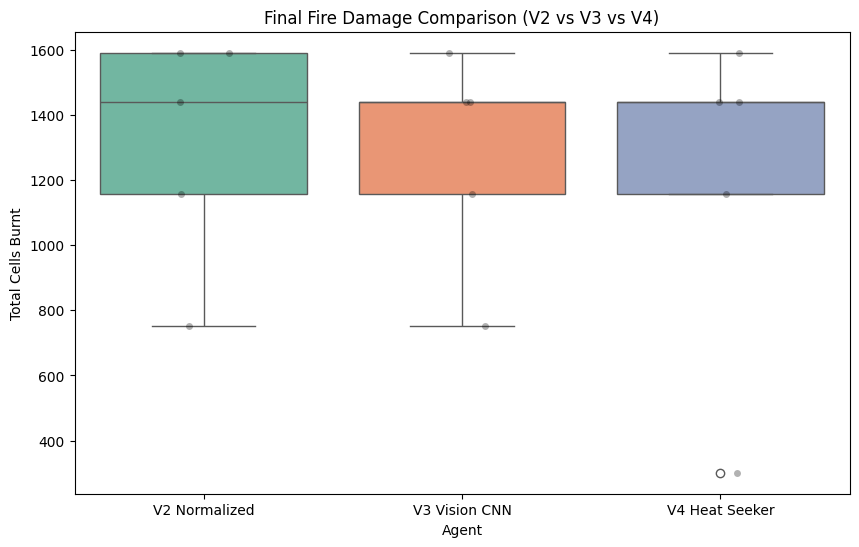

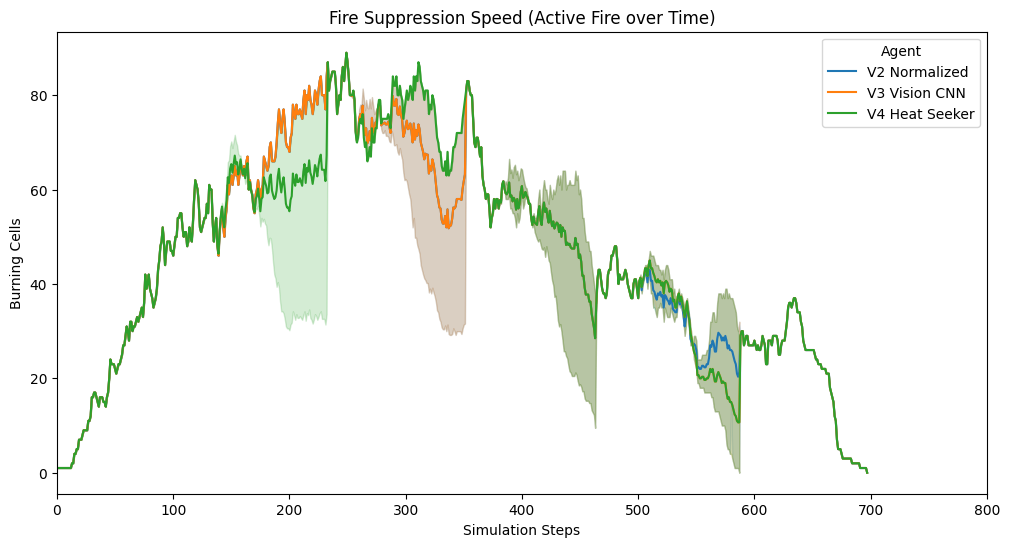

✅ Plots saved to Drive!


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gymnasium as gym
import numpy as np
from stable_baselines3 import PPO
from firecastrl_env.envs.wildfire_env import WildfireEnv

# redefining wrappers to ensure correct model loading during evaluation
class SmartNormalizeWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.grid_w = env.gridWidth
        self.grid_h = env.gridHeight
    def observation(self, obs):
        grid = np.nan_to_num(obs['cells'], posinf=-1.0)
        obs['cells'] = np.clip(grid / 1000.0, -1.0, 1.0)
        coords = obs['helicopter_coord'].astype(np.float32)
        coords[:, 0] /= float(self.grid_w)
        coords[:, 1] /= float(self.grid_h)
        obs['helicopter_coord'] = coords
        return obs

class VisionWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        h, w = env.gridHeight, env.gridWidth
        self.observation_space = gym.spaces.Dict({
            'cells': gym.spaces.Box(low=-1.0, high=1.0, shape=(1, h, w), dtype=np.float32),
            'helicopter_coord': env.observation_space['helicopter_coord'],
            'quenched_cells': env.observation_space['quenched_cells']
        })
        self.grid_w = w
        self.grid_h = h
    def observation(self, obs):
        grid = np.nan_to_num(obs['cells'], posinf=-1.0)
        grid = np.clip(grid / 1000.0, -1.0, 1.0)
        new_grid = grid.reshape(1, self.grid_h, self.grid_w)
        coords = obs['helicopter_coord'].astype(np.float32)
        coords[:, 0] /= float(self.grid_w)
        coords[:, 1] /= float(self.grid_h)
        return {
            'cells': new_grid.astype(np.float32),
            'helicopter_coord': coords,
            'quenched_cells': obs['quenched_cells']
        }

# defining function to evaluate agents and collect plotting data
def run_eval_for_plot(model_path, agent_name, wrapper_type="normal", episodes=5):
    print(f"📊 Evaluating: {agent_name}...")

    raw_env = WildfireEnv(num_agents=3, render_mode=None)

    # selecting the appropriate environment wrapper based on model type
    if wrapper_type == "vision":
        env = VisionWrapper(raw_env)
    elif wrapper_type == "normalize":
        env = SmartNormalizeWrapper(raw_env)
    else:
        # using normalization wrapper as default fallback
        env = SmartNormalizeWrapper(raw_env)

    try:
        model = PPO.load(model_path)
    except:
        print(f"   ❌ Model not found: {model_path}")
        return None, None

    stats = []
    curves = []

    for ep in range(episodes):
        obs, _ = env.reset()
        done = False
        step = 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, _, term, trunc, info = env.step(action)
            done = term or trunc

            # recording fire size data for step-by-step plotting
            curves.append({
                "Agent": agent_name,
                "Episode": ep,
                "Step": step,
                "FireSize": info['cells_burning']
            })
            step += 1

        # storing final episode statistics
        stats.append({
            "Agent": agent_name,
            "Burnt": info['cells_burnt'],
            "Steps": step
        })

    return pd.DataFrame(stats), pd.DataFrame(curves)

# defining model paths and configurations for testing
models_to_test = [
    ("V2 Normalized", f"{save_dir}/ppo_fire_squad_v2_normalized", "normalize"),
    ("V3 Vision CNN", f"{save_dir}/ppo_fire_squad_v3_cnn", "vision"),
    ("V4 Heat Seeker", f"{save_dir}/ppo_fire_squad_v4_heatseeker", "vision") # specifying vision wrapper for v4 heat seeker model
]

all_stats = []
all_curves = []

for name, path, w_type in models_to_test:
    df_s, df_c = run_eval_for_plot(path, name, w_type)
    if df_s is not None:
        all_stats.append(df_s)
        all_curves.append(df_c)

if not all_stats:
    print("❌ No data collected!")
else:
    final_stats = pd.concat(all_stats)
    final_curves = pd.concat(all_curves)

    # generating boxplot to compare total fire damage across agents
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=final_stats, x="Agent", y="Burnt", palette="Set2")
    sns.stripplot(data=final_stats, x="Agent", y="Burnt", color="black", alpha=0.3)
    plt.title("Final Fire Damage Comparison (V2 vs V3 vs V4)")
    plt.ylabel("Total Cells Burnt")
    plt.savefig(f"{save_dir}/final_damage_comparison.png")
    plt.show()

    # plotting fire suppression speed over time
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=final_curves, x="Step", y="FireSize", hue="Agent")
    plt.title("Fire Suppression Speed (Active Fire over Time)")
    plt.ylabel("Burning Cells")
    plt.xlabel("Simulation Steps")
    plt.xlim(0, 800) # limiting x-axis to focus on early simulation phase
    plt.savefig(f"{save_dir}/final_suppression_curve.png")
    plt.show()

    print("✅ Plots saved to Drive!")